# Coursework 1: Gaussian processes
_[Original](http://mlg.eng.cam.ac.uk/teaching/4f13/1718/cw/coursework1.pdf) by Carl Rasmussen and Manon Kok for [CUED course 4f13](http://mlg.eng.cam.ac.uk/teaching/4f13/1718/). This version adapted by Damon Wischik._

In this assignment you will use Gaussian process modelling.
This coursework uses the Python package [`sklearn.gaussian_process`](http://scikit-learn.org/stable/modules/gaussian_process.html) which is the rough equivalent of the [GPML](http://www.gaussianprocess.org/gpml/code/matlab/doc/) package for MATLAB. See the appendix at the end of this document for a walkthrough.

In [ ]:
# Standard imports for scientific and engineering work in Python:
import numpy as np                      # MATLAB-style matrix and vector manipulation
import matplotlib.pyplot as plt         # MATLAB-style plotting
import matplotlib                       # for more control over plotting
import scipy.io                         # some useful data input-output routines
import sklearn.gaussian_process as gp   # Gaussian process modeling
import requests                         # for retrieving data over the web
import io                               # also used for importing data
# Configure matplotlib to show its output right in the notebook
%matplotlib inline

## Question (a)

Load data from `https://teachingfiles.blob.core.windows.net/probml/cw1a.mat`. Consider a Gaussian process with a squared exponential covariance function,
```
ν**2 * gp.kernels.RBF(length_scale=λ) + gp.kernels.WhiteKernel(noise_level=σ),
```
and minimize the negative log marginal likelihood starting with hyperparameters `λ=np.exp(-1)`, `ν=1`, `σ=1`. Show the 95% predictive error bars. Comment on the predictive error bars and the optimized hyperparameters.

In [14]:
# To import a .mat file from a URL:
r = requests.get('https://teachingfiles.blob.core.windows.net/probml/cw1a.mat')
with io.BytesIO(r.content) as f:
    data = scipy.io.loadmat(f)
    x,y = data['x'], data['y']

## Question (b)

Show that by initializing the hyperparameters differently, you can ﬁnd a different local optimum for the hyperparameters. Try a range of values. Show the fit. Explain what is going on. Which fit is best, and why? 

## Question (c)

Train instead a GP with a periodic covariance function, using [`gp.kernels.ExpSineSquared`](http://scikit-learn.org/stable/modules/gaussian_process.html#exp-sine-squared-kernel). Show the fit. Comment on the
behaviour of the error-bars, compared to your fit from (a). Do you think the data generating mechanism
was really periodic? Why, why not?

## Question (d)

Generate 200 noise-free data points at `x = np.linspace(-5,5,200)` from a Gaussian process with the following
covariance function: 
```
1 * gp.kernels.ExpSineSquared(length_scale=np.exp(-0.5), periodicity=1) 
    * gp.kernels.RBF(length_scale=np.exp(2)))
```
Don’t add noise to the function values, i.e. don't add `gp.kernels.WhiteKernel()` to the kernel.
Using `GaussianProcessRegressor.sample_y()`, plot some sample functions. Explain their behaviour.

## Question (e)

Load `https://teachingfiles.blob.core.windows.net/probml/cw1e.mat`. This data has two-dimensional input and scalar output. Visualise the data, e.g. using the code snippets in the appendix.
Compare two Gaussian process models of the data, one using covariance function
`RBF(length_scale=[l1,l2])`
and the other using the sum of two such `RBF` terms. (Make sure to break symmetry, e.g. by choosing the initial hyperparameters randomly.)

When `length_scale` is a list, the `RBF` kernel uses separate length-scale parameters for each dimension of the input space. In GPML it is known as 'Squared Exponential with Automatic Relevance Determination', `covSEard`. It is a useful tool to learn which inputs are important for predictions: if length-scales are short, inputs are very important, and when they grow very long (compared to the spread of the data), the corresponding inputs will be largely ignored.

In [3]:
r = requests.get('https://teachingfiles.blob.core.windows.net/probml/cw1e.mat')
with io.BytesIO(r.content) as f:
    data = scipy.io.loadmat(f)
    x,y = data['x'], data['y']

<div style="height: 15em"></div>

# Appendix

## Gaussian processes in Python

Here is a simple example of how to use `sklearn.gaussian_process`. For full details, see the [documentation](http://scikit-learn.org/stable/modules/gaussian_process.html).

Let's consider a simple Gaussian process model: a prior on the space of Gaussian processes, with mean 0, and with covariance function
$$
k(x, x') = \nu^2 \exp \Bigl( -\frac{(x-x')^2}{2\ell^2}\Bigr)
$$
(this function is called `RBF` in `sklearn.gaussian_process` and `covSEiso` in GPML). Suppose that the data model is  
$$
p(y\:|\:x,f) \sim
\operatorname{Normal}\bigl(f(x), \sigma^2 I\bigr)
$$
where $x$ and $y$ are vectors and $f(x)$ means $(f(x_1),\dots,f(x_n))$. In this model, $\nu$, $\ell$ and $\sigma$ are hyperparameters. Another way to write out this entire model is with a single covariance function,
$$
k(x, x') = \nu^2 \exp \Bigl( -\frac{(x-x')^2}{2\ell^2}\Bigr) + \sigma^2 \delta_{x x'}.
$$

In the `gaussian_process` package, a Gaussian process model is specified by a _kernel_ object. (Kernel is another name for covariance function.) The package has a [library of kernels](http://scikit-learn.org/stable/modules/gaussian_process.html#gp-kernels), each implemented as a Python class, and we can create composite kernels by adding together and multiplying kernel objects.

In [18]:
l = np.exp(-1)
ν = 0.5
σ = 1
kernel1 = ν**2 * gp.kernels.RBF(length_scale=l) + gp.kernels.WhiteKernel(noise_level=σ)
kernel1

0.5**2 * RBF(length_scale=0.368) + WhiteKernel(noise_level=1)

To extract parameters from a kernel, use `get_params()`. You can also use `set_params` to set the parameters for a kernel.

In [19]:
kernel1.get_params()

{'k1': 0.5**2 * RBF(length_scale=0.368),
 'k1__k1': 0.5**2,
 'k1__k1__constant_value': 0.25,
 'k1__k1__constant_value_bounds': (1e-05, 100000.0),
 'k1__k2': RBF(length_scale=0.368),
 'k1__k2__length_scale': 0.36787944117144233,
 'k1__k2__length_scale_bounds': (1e-05, 100000.0),
 'k2': WhiteKernel(noise_level=1),
 'k2__noise_level': 1,
 'k2__noise_level_bounds': (1e-05, 100000.0)}

Machine learning functions are implemented via the class `GaussianProcessRegressor`, which is initialized with a kernel object. It has methods for learning hyperparameters and making predictions. We can access a model's kernel with `GaussianProcessRegressor.kernel`.

In [20]:
model1 = gp.GaussianProcessRegressor(kernel=kernel1)
model1.kernel

0.5**2 * RBF(length_scale=0.368) + WhiteKernel(noise_level=1)

To learn hyperparameters, use `GaussianProcessRegressor.fit(x,y)`. It requires the parameters to be arrays with one row per observation. In the example below we start with one-dimensional input and output, so we have to reshape them to be column vectors. We can access the fitted kernel, and thence the fitted parameters, with `model.kernel_`.

In [22]:
# Training data
x = np.array([0.57650, 0.43504, 0.76607, -0.78369, -1.27129, -0.66034, 1.18100, 
              0.25929, 0.50898, -0.73703, 0.83023, 1.60078, -0.34655, -0.68073, 
              -1.21480, -0.55955, -1.28229, 0.85388, 0.73265, -0.75330])
y = np.array([ 0.96948, 1.08384, 0.62050, -0.65940, 0.54944, -0.88911, -0.37886,
              0.77166, 0.97753, -0.75901, 0.76003, -1.13327, -0.74600, -0.99293,
              0.60169, -0.98088, 0.55333, 0.60247, 0.99501, -0.83345])

model1.fit(x[..., np.newaxis], y[..., np.newaxis])
model1.kernel_

0.901**2 * RBF(length_scale=0.53) + WhiteKernel(noise_level=0.00852)

To make predictions with a fitted model, call `GaussianProcessRegressor.predict(x)`. As before, `x` should be a column vector.

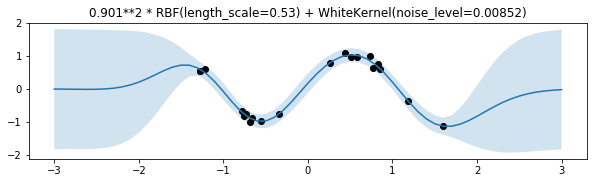

In [23]:
# New values of x where we want to make a prediction
newx = np.linspace(-3, 3, 61)
μ,σ = model1.predict(newx[..., np.newaxis], return_std=True)

# Plot the output.
# squeeze() is a numpy function that turns column vectors into simple 1d vectors.
with matplotlib.rc_context({'figure.figsize': [10,2.5]}):
    plt.fill_between(newx, μ.squeeze()-2*σ, μ.squeeze()+2*σ, alpha=.2)
    plt.plot(newx, μ.squeeze())
    plt.scatter(x, y, color='black')
    plt.title(model1.kernel_)
plt.show()

## Plotting a function of two variables

Here are some ways we might plot the data from part (e).

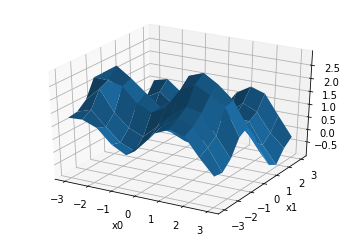

In [4]:
from mpl_toolkits.mplot3d import axes3d   # import a library to allow 3d plots

# Reshape the data to be in array form
X = x[:,0].reshape((11,11))
Y = x[:,1].reshape((11,11))
Z = y.reshape((11,11))

# Optionally: use `%matplotlib notebook` to make the plots interactive.
# Get axes for a 3d plot, and then plot the surface
axes = plt.figure().gca(projection='3d')
axes.plot_surface(X, Y, Z)
axes.set_xlabel('x0')
axes.set_ylabel('x1')
plt.show()

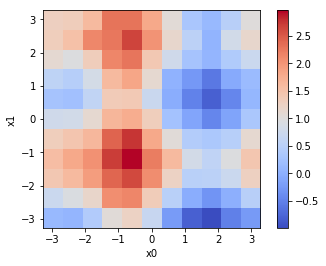

In [5]:
# A heatmap
plt.imshow(y.reshape((11,11)), extent=np.array([-3,3,-3,3])*12/11, cmap=plt.get_cmap('coolwarm'))
plt.xlabel('x0')
plt.ylabel('x1')
plt.colorbar()
plt.show()